# Recommender system

### 1.0  movielens small som består av 100,000 ratings på 9000 filmer och 600 användare
- downloading the dataset

In [3]:
import pandas as pd

movies = 'Data1/ml-latest-small/ml-latest-small/movies.csv'
ratings = 'Data1/ml-latest-small/ml-latest-small/ratings.csv'

df_movies = pd.read_csv(movies, usecols=['movieId','title'], dtype={'movieId':'int32', 'title':'str'} )

In [4]:
df_movies.head()
# time 4.32

df_movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [5]:
df_ratings = pd.read_csv(ratings, usecols=['userId', 'movieId', 'rating'], dtype={'userId':'int32', 'movieId':'int32', 'rating':'float32'})

In [6]:
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [7]:
# 9:20 
from scipy.sparse import csr_matrix 

movies_uesers=df_ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)
mat_movies_users=csr_matrix(movies_uesers.values)

In [8]:
from sklearn.neighbors import NearestNeighbors
# Euclidean distance
# Manhattan distance
# Minowski distance
# cosine similarity

model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
model_knn.fit(mat_movies_users)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [9]:
from fuzzywuzzy import process
# recommender function
def recommender(movie_name, data, model, n_recommendations):
    model.fit(data)
    idx=process.extractOne(movie_name, df_movies['title'])[2]
    print('Movier selected:',df_movies['title'][idx],' Index', idx)
    print(' Searching for recommendations .....')
    distances, indices = model.kneighbors(data[idx], n_neighbors=n_recommendations)
    #print(distances, indices )
    for i in indices:
        print(df_movies['title'][i].where(i!=idx))

recommender('toy story', mat_movies_users, model_knn, 20)

c:\Source\AI-recomend_predict\venv\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Movier selected: Toy Story (1995)  Index 0
 Searching for recommendations .....
0                                                     NaN
2353                                 'night Mother (1986)
418                                  Jurassic Park (1993)
615                  Independence Day (a.k.a. ID4) (1996)
224             Star Wars: Episode IV - A New Hope (1977)
314                                   Forrest Gump (1994)
322                                 Lion King, The (1994)
910     Once Upon a Time in the West (C'era una volta ...
546                            Mission: Impossible (1996)
963                                           Diva (1981)
968                           Arsenic and Old Lace (1944)
3189            Rififi (Du rififi chez les hommes) (1955)
506                                        Aladdin (1992)
123                                      Apollo 13 (1995)
257                                   Pulp Fiction (1994)
897                 Cheech and Chong's Up in Smoke

## 1.1 - Movielens full - EDA


Läs in dataseten "movies.csv" och "ratings.csv"



In [10]:

movies = 'Data2/ml-latest/ml-latest/movies.csv'
ratings = 'Data2/ml-latest/ml-latest/ratings.csv'

df_movies = pd.read_csv(movies, usecols=['movieId','title'], dtype={'movieId':'int32', 'title':'str'} )
df_ratings = pd.read_csv(ratings, usecols=['userId', 'movieId', 'rating'], dtype={'userId':'int32', 'movieId':'int32', 'rating':'float32'})

# 86,000 movies by 330,975 users.

#df_movies.info()
df_ratings.describe()
df_ratings.head()




,userId,movieId,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# räkna om så att antal röster per film 
df_test=df_ratings.loc[(df_ratings.groupby(['movieId'])['userId'].count())]


# ta bara hänsyn till de som har fler än 1000 omdömmen
df_test2=df_test[df_test.index>1000]

# df_test.head()






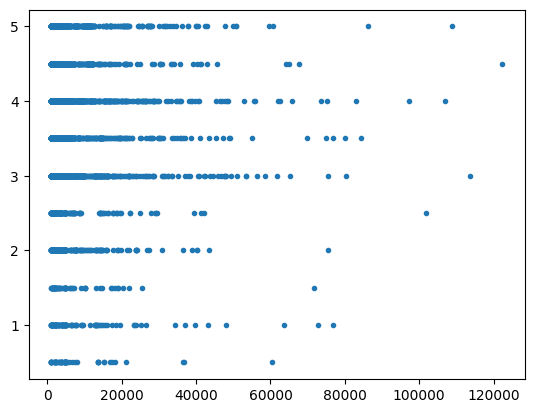

In [12]:
plt.plot(df_test2.index, df_test2['rating'], '.')
plt.show()

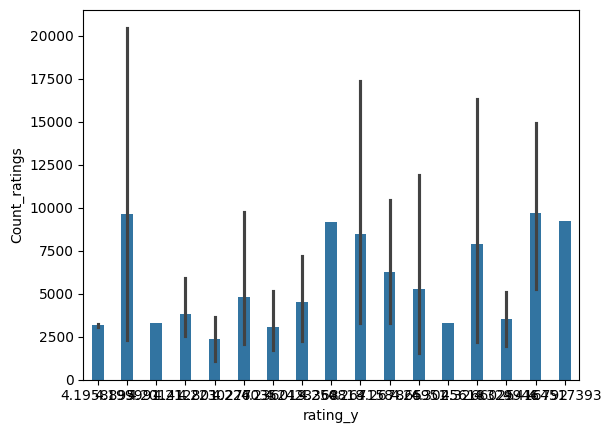

In [68]:
df_test3=df_ratings.groupby(['movieId'])['rating'].mean()
df_A=df_test2.rename_axis('Count_ratings').reset_index()
df_B=df_test3.rename_axis('movieId').reset_index()
df_all=pd.merge(df_A, df_B, on='movieId', how='inner').sort_values(by='rating_y',ascending = False)

snsplot=sns.barplot(data = df_all.head(100), x = "rating_y", y = "Count_ratings", width=0.4 )
#snsplot.set_xticks(range(10))
xlabels = ['{:,.2f}'.format(x) for x in snsplot.get_xticks()]
# snsplot.set_xticklabels(xlabels)
# snsplot.set_xticklabels(
#     snsplot.get_xticklabels(), 
#     rotation=45, 
#     horizontalalignment='right'
# )

In [71]:
# xlabels = ['{:,.2f}'.format(x) for x in snsplot.get_xticks()]
# pd.merge(restaurant_ids_dataframe, restaurant_review_frame, on='business_id', how='outer')

snsplot.get_xticks()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [38]:
#pd.DataFrame(df_test3).columns(['movieID', 'rating'])
df_test2.rename_axis('Count_ratings').reset_index()

,Count_ratings,userId,movieId,rating
0,76813,821,8529,1.0
1,30209,305,81562,4.5
2,15820,160,1214,4.0
3,3028,30,202429,5.0
4,15801,160,785,4.0
...,...,...,...,...
4456,1411,21,3361,3.5
4457,1145,16,136016,4.5
4458,1887,22,138835,4.0
4459,1409,21,3275,4.5


a)  EDA
b)  Vilka är de 10 filmerna med flest ratings
c)  Genomsnittliga ratingen för dessa 10 filmerna med flest ratings.
d)  Gör en plot över årtal och antalet filmer representerade i datasetet.
e)  Gör en plot över antalet ratings mot movieId.
f)  Beräkna genomsnittliga ratings för de top 10 filmerna med flest ratings. Gör ett stapeldiagram över dessa.

In [ ]:
df_test3.colname

movieId
1         3.893508
2         3.278179
3         3.171271
4         2.868395
5         3.076957
            ...   
288967    3.500000
288971    0.500000
288975    4.000000
288977    3.000000
288983    3.000000
Name: rating, Length: 83239, dtype: float32

In [ ]:
df_ratings.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 387.2 MB
